# Set up

In [1]:
import pandas as pd
from tqdm.auto import tqdm

from util_functions import (
    retrieve_uniprot_data_by_acess,
    get_domain,
    rename_for_lab,
    save_df_to_fasta,
    read_blast,
    align,
    print_heatmap,
    get_pictures,
    get_genes_for_point_aln
)

# Get acess id for known Ly6/uPAR genes

# Retrieve all known Ly6/uPAR genes from uniprot by acess

# Retrieve LU-domains from protein sequences

# Rename some ids

In [2]:
# Save preprocessed data
short = pd.read_csv('seqs/csv/short_upar_all_data.csv')

# Blast

In [3]:
aru = read_blast('arubens_seq.csv', 'Asterias rubens')
apl = read_blast('aplanci_seq.csv', 'Acanthaster planci')

apl = apl.drop('XP_022094806.1_|_Acanthaster_planci')
x706 = aru.loc['XP_033635706.1_|_Asterias_rubens']
algo_index = x706.sequence.index(x706.domain)
moved_index = algo_index + 23
aru.loc['XP_033635706.1_|_Asterias_rubens', 'domain'] = x706.sequence[moved_index:+moved_index + len(x706.domain) - 5]

print(aru.shape[0], apl.shape[0])

5 6


# MSA

# Pictures

## Get heatmaps of blast hits

## Plot alignments

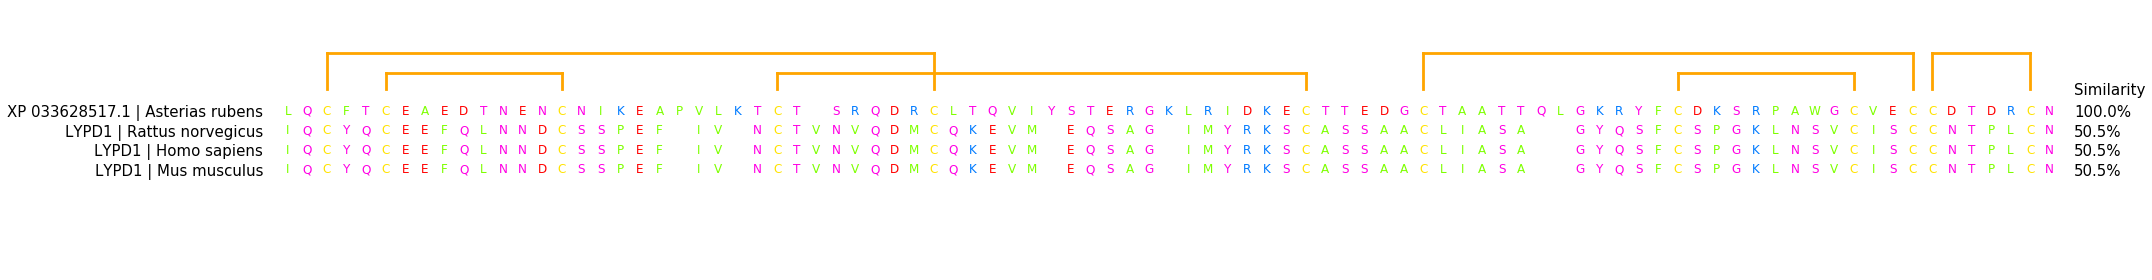

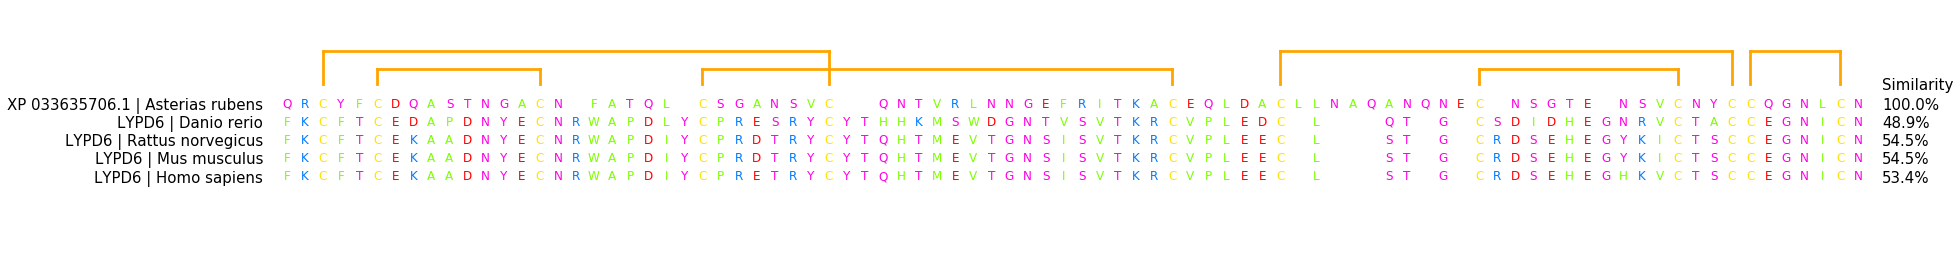

XP_033635707.1 protein has duplicated domain
 "None of [Index(['XP_033635707.1_|_Asterias_rubens'], dtype='object', name='genes')] are in the [index]"
XP_033635708.1 protein has duplicated domain
 "None of [Index(['XP_033635708.1_|_Asterias_rubens'], dtype='object', name='genes')] are in the [index]"


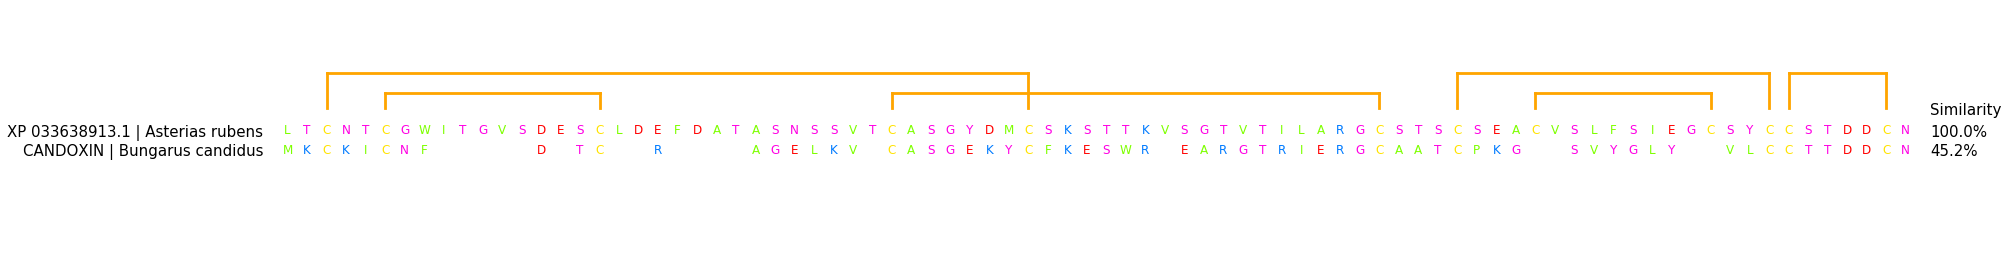

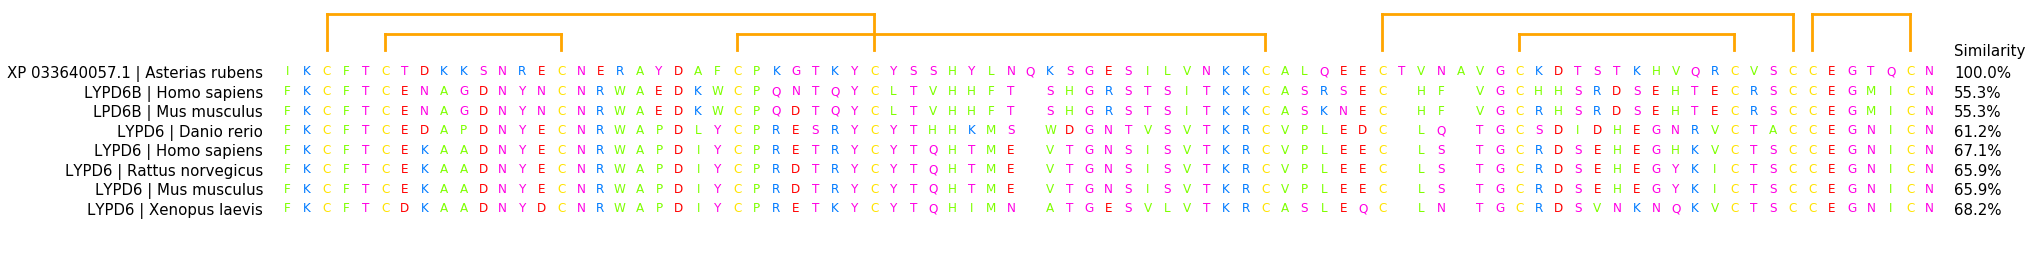

XP_033640058.1 protein has duplicated domain
 "None of [Index(['XP_033640058.1_|_Asterias_rubens'], dtype='object', name='genes')] are in the [index]"


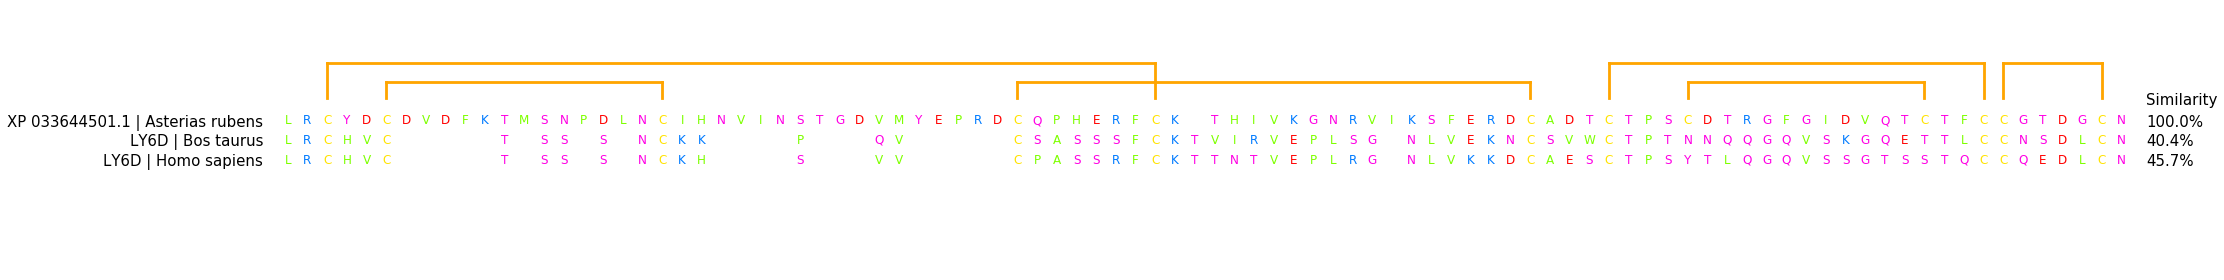

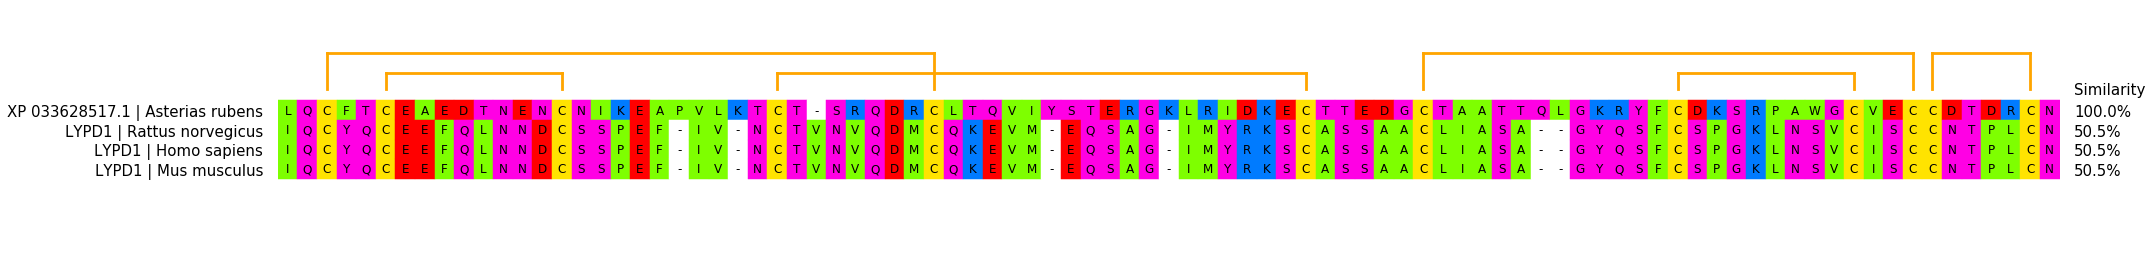

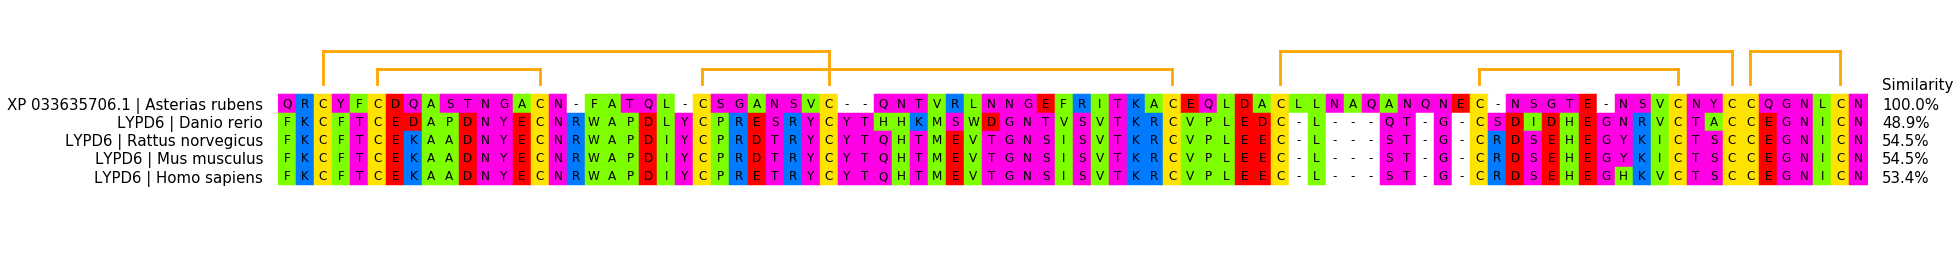

XP_033635707.1 protein has duplicated domain
 "None of [Index(['XP_033635707.1_|_Asterias_rubens'], dtype='object', name='genes')] are in the [index]"
XP_033635708.1 protein has duplicated domain
 "None of [Index(['XP_033635708.1_|_Asterias_rubens'], dtype='object', name='genes')] are in the [index]"


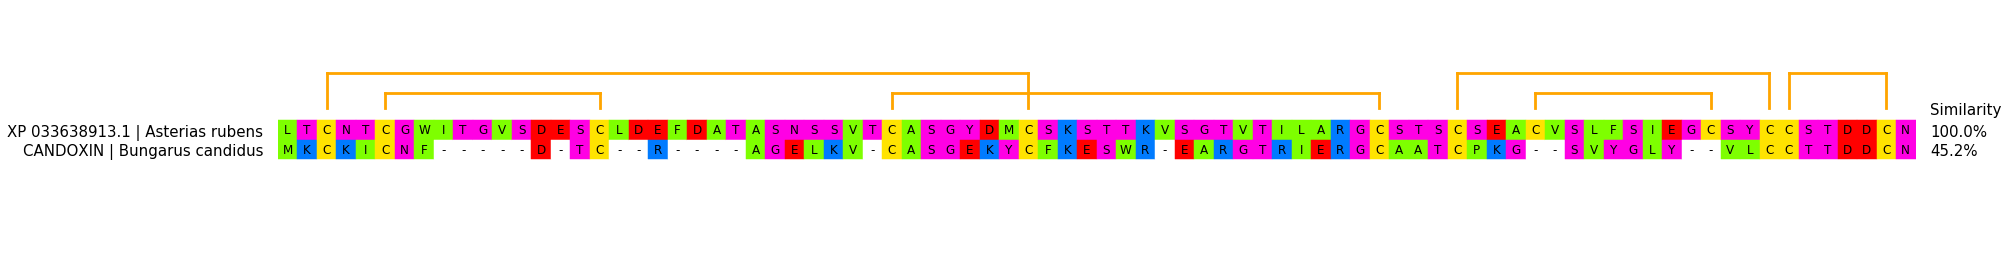

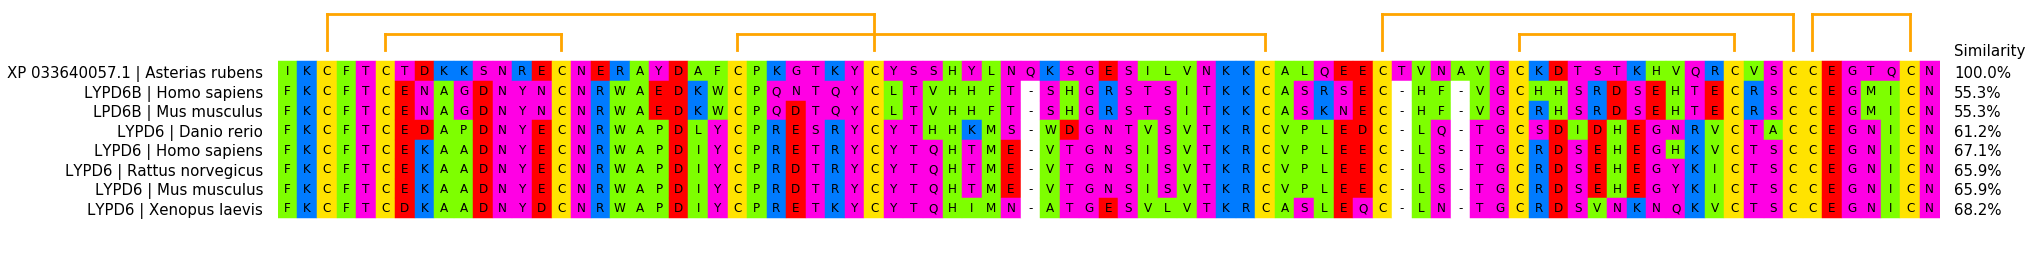

XP_033640058.1 protein has duplicated domain
 "None of [Index(['XP_033640058.1_|_Asterias_rubens'], dtype='object', name='genes')] are in the [index]"


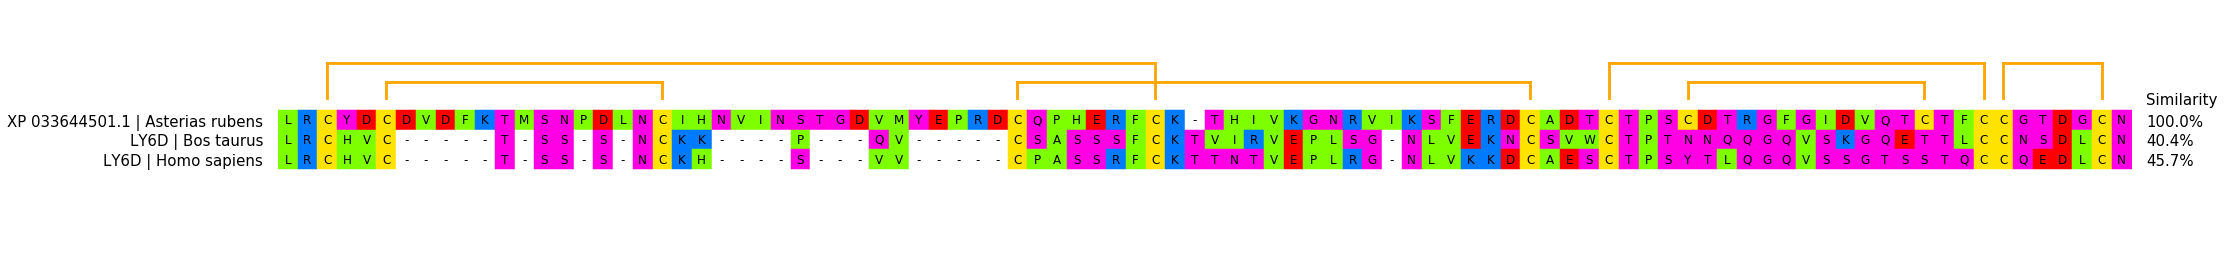

In [4]:
organism = 'Asterias rubens'
df = get_genes_for_point_aln('arubens')
get_pictures(star_blast=aru, df=df, uniprot=short, organism=organism, color_symbols=True)
get_pictures(star_blast=aru, df=df, uniprot=short, organism=organism, color_symbols=False)

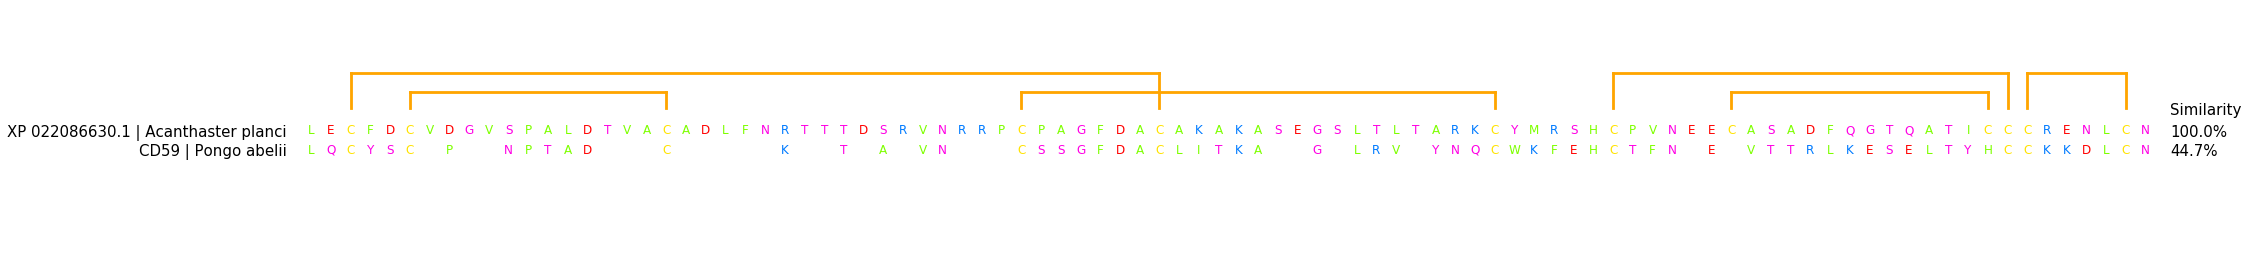

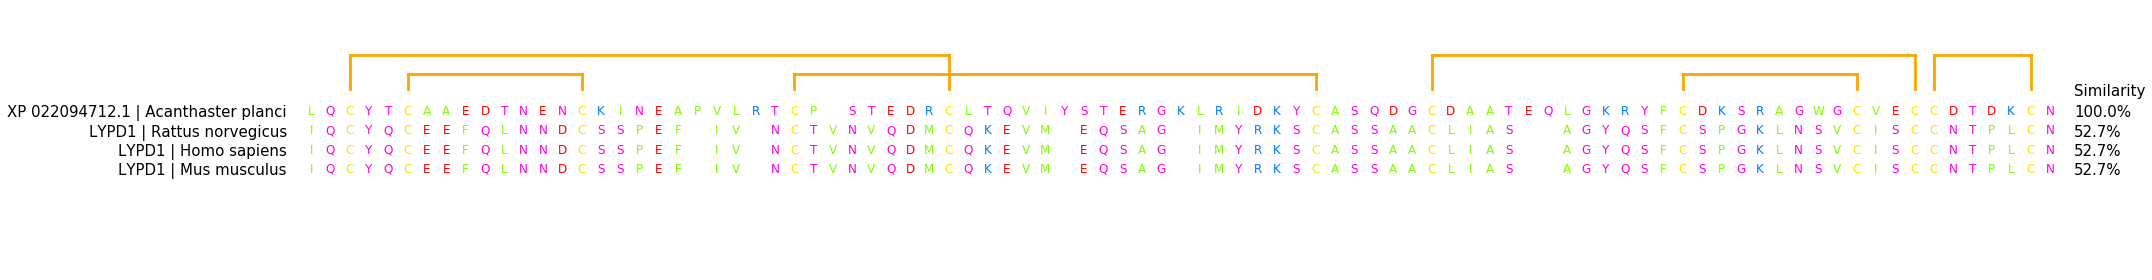

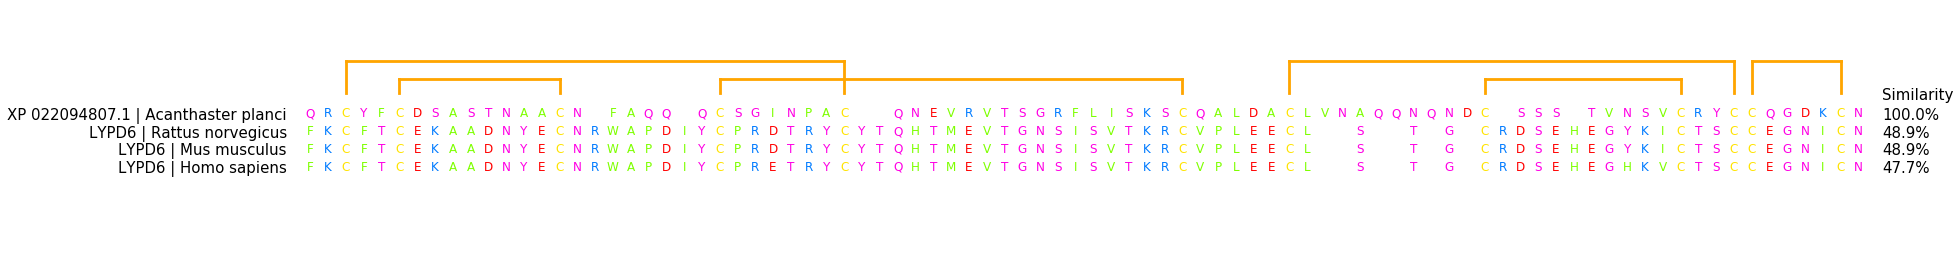

XP_022094806.1 protein has duplicated domain
 "None of [Index(['XP_022094806.1_|_Acanthaster_planci'], dtype='object', name='genes')] are in the [index]"


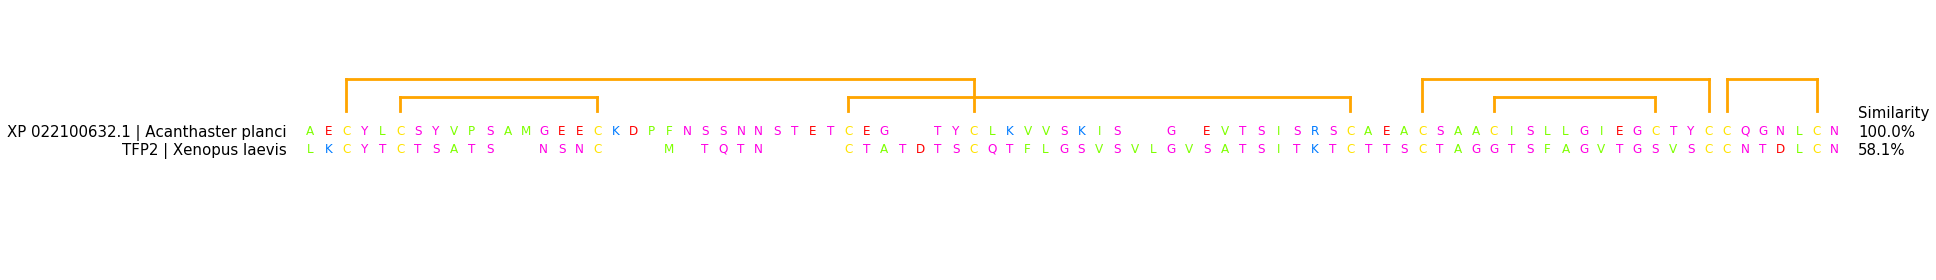

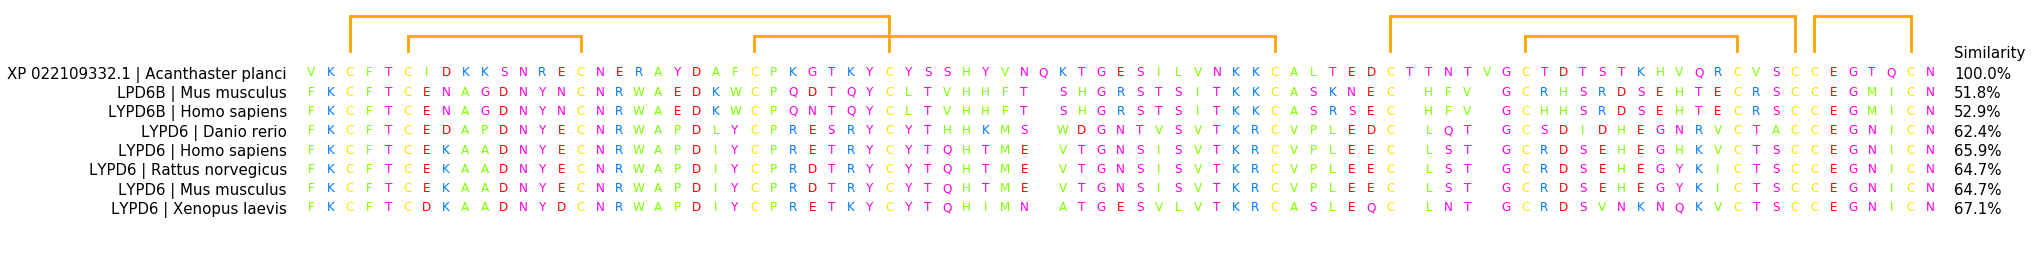

XP_022109331.1 protein has duplicated domain
 "None of [Index(['XP_022109331.1_|_Acanthaster_planci'], dtype='object', name='genes')] are in the [index]"


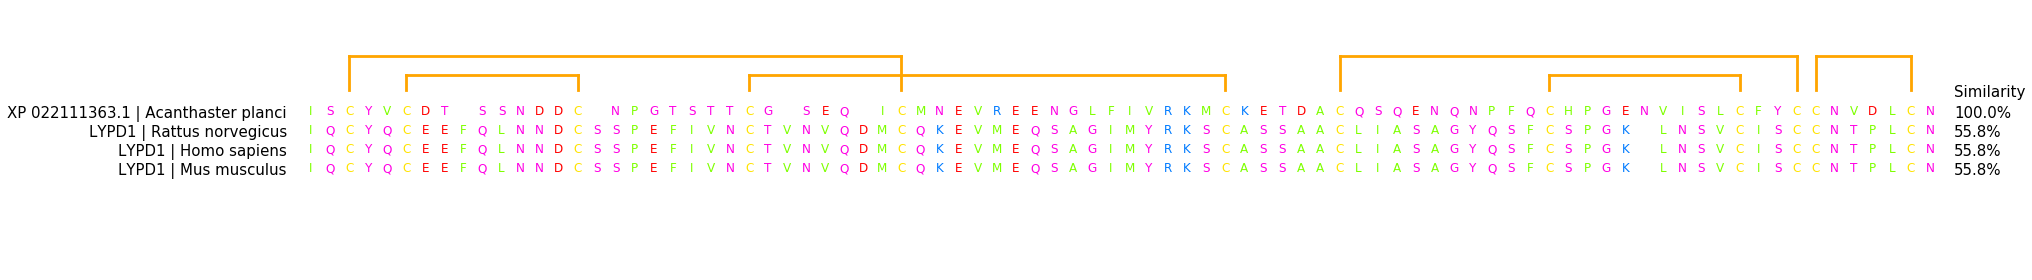

XP_022111364.1 protein has duplicated domain
 "None of [Index(['XP_022111364.1_|_Acanthaster_planci'], dtype='object', name='genes')] are in the [index]"


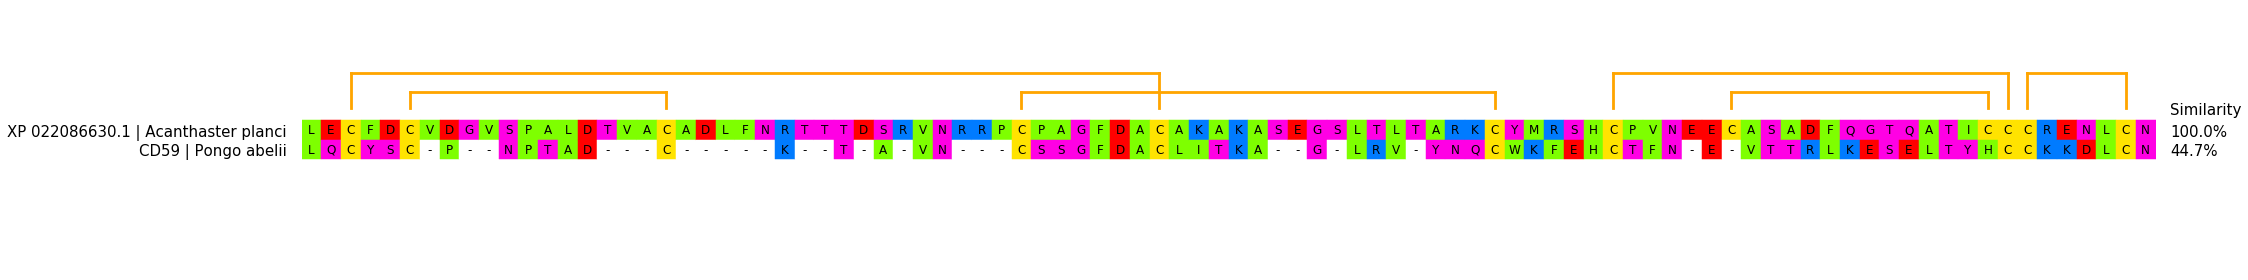

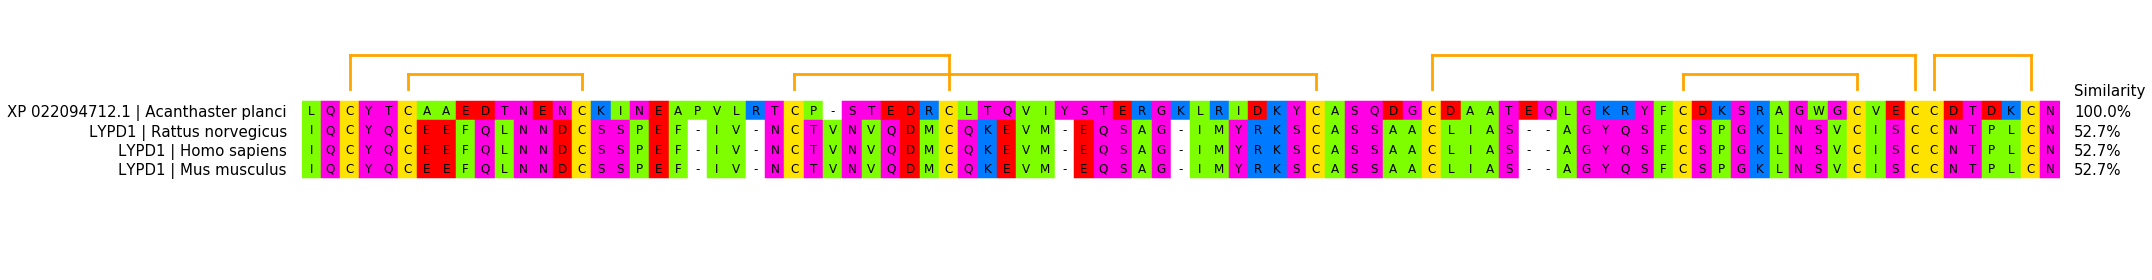

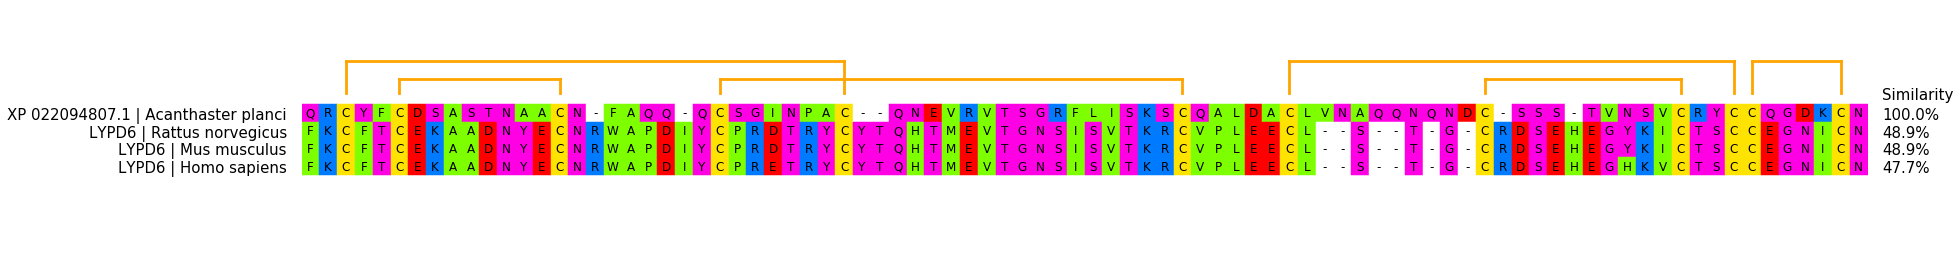

XP_022094806.1 protein has duplicated domain
 "None of [Index(['XP_022094806.1_|_Acanthaster_planci'], dtype='object', name='genes')] are in the [index]"


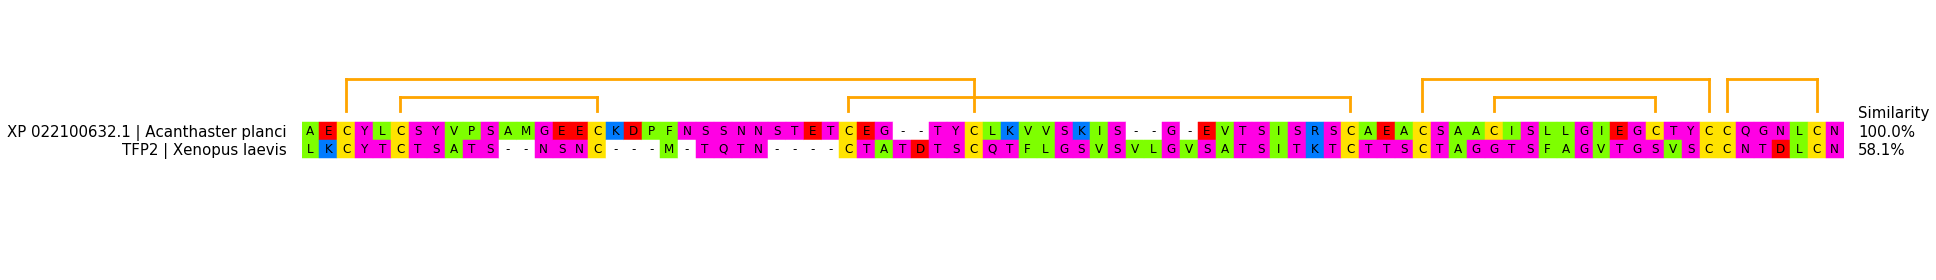

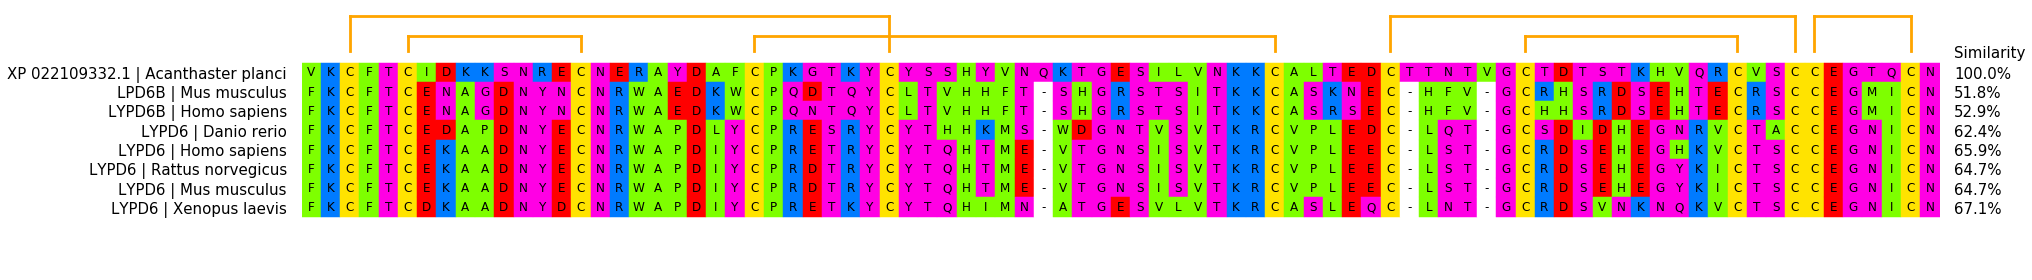

XP_022109331.1 protein has duplicated domain
 "None of [Index(['XP_022109331.1_|_Acanthaster_planci'], dtype='object', name='genes')] are in the [index]"


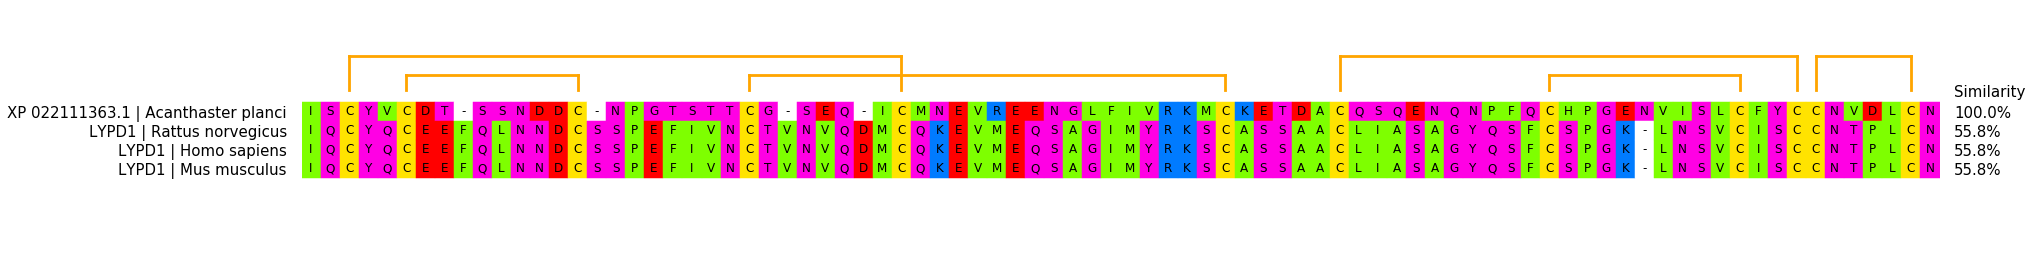

XP_022111364.1 protein has duplicated domain
 "None of [Index(['XP_022111364.1_|_Acanthaster_planci'], dtype='object', name='genes')] are in the [index]"


In [5]:
organism = 'Acanthaster planci'
df = get_genes_for_point_aln('aplanci')
get_pictures(star_blast=apl, df=df, uniprot=short, organism=organism, color_symbols=True)
get_pictures(star_blast=apl, df=df, uniprot=short, organism=organism, color_symbols=False)

# Get dataset for ITOL

# Shabelnikov

In [6]:
df = pd.read_csv(f'shabelnikov/unlimited_search_blast_short.txt', index_col=0, sep='\t', header=None).rename(columns={
    1: 'Ly6/uPAR',
    2: 'percent ident',
    3: 'length',
    4: 'mismatch',
    5: 'gapopen',
    6: 'Star protein start',
    7: 'Star protein end',
    8: 'Ly6/uPAR start',
    9: 'Ly6/uPAR end',
    11: 'bit-score',
    10: 'e-value'
})
df.index.name = 'Star protein'

with open('shabelnikov/LYSTARS_Shab.fasta') as f:
    proteins = {(ls := line.split('-'))[0].strip('>'): ls[1].strip() for line in f.readlines() if line.startswith('>')}    

shab = df.loc[proteins].sort_values('e-value')
shab['Star Protein NAME'] = shab.index.map(proteins.get)
(val := shab['e-value'].min(), val > 1e-5)

(0.000161, True)

In [7]:
def util(df, name, val):
    df[df['e-value'] <= val].to_csv(f'shabelnikov/limit_by_{name}_blast_short.txt', header=None, sep='\t')
    tmp = read_blast('arubens_seq.csv', 'Asterias rubens', path='shabelnikov', bl_name=f'limit_by_{name}', domain=False)
    print(tmp.shape[0])
    return tmp

In [8]:
(one := shab['e-value'].min())

0.000161

In [9]:
util(df, 'one', one)

16


,sequence,gene_len,org
genes,,,
XP_033628517.1_|_Asterias_rubens,MRIKMVFKFRRNSEGIFCILMTLMIILMAVCFRTASSLQCFTCEAE...,155,Asterias rubens
XP_033627815.1_|_Asterias_rubens,MYSWWASMQPDIEGDSNNRSVLQSFPENVGREVVLSVVRQLANHLS...,1531,Asterias rubens
XP_033627807.1_|_Asterias_rubens,MYSWWASMQPDIEGDSNNRSVLQSFPENVGREVVLSVVRQLANHLS...,1550,Asterias rubens
XP_033627087.1_|_Asterias_rubens,MKLIIFTLILAFPGQVECLDCYTCTYGIETLRTNTAACGDPFNTNG...,132,Asterias rubens
XP_033629377.1_|_Asterias_rubens,MCYCQQGYQTTKNRRTCEDLNECQDHSIHGCDQTCLNSEGSYSCSC...,4391,Asterias rubens
XP_033629378.1_|_Asterias_rubens,MCYCQQGYQTTKNRRTCEDLNECQDHSIHGCDQTCLNSEGSYSCSC...,4364,Asterias rubens
XP_033635539.1_|_Asterias_rubens,MLVPGLLLLLWLVCGLHGAIPDVCQDGTGDGGNGQPCDCWRTSDGN...,1022,Asterias rubens
XP_033635706.1_|_Asterias_rubens,MLMSNQHQCSMYSLRLLLLVVAIMYDATLVMGQTACSVADPVCRCT...,1123,Asterias rubens
XP_033635708.1_|_Asterias_rubens,MLMSNQHQCSMYSLRLLLLVVAIMYDATLVMGQTACSVADPVCRCT...,1111,Asterias rubens


In [10]:
(all_ := shab.groupby('Star protein')['e-value'].min().max())

0.088

In [11]:
util(df, 'all', all_)

1468


,sequence,gene_len,org
genes,,,
XP_033626624.1_|_Asterias_rubens,MSETSAEKGRSDGNTSKHRWKILRNAILKKQCQHTDPVKSVSVRRF...,297,Asterias rubens
XP_033626630.1_|_Asterias_rubens,MSETSAEKGRSDGNTSKHRWKILRNAILKKQCQHTDPVKSVSVRRF...,280,Asterias rubens
XP_033636748.1_|_Asterias_rubens,MFCEKVLELIRELKRSLDGTLLPFNEDGVRQVLEEMKALYDQNQTD...,194,Asterias rubens
XP_033627243.1_|_Asterias_rubens,MSGFDSQGIFFSDNFGSEDPQGDGVNRAAVQRRFKDFLRKYHDANF...,733,Asterias rubens
XP_033631297.1_|_Asterias_rubens,MAIGTGNSCKINEPDDELPDVKTSHDCYLSYYSTLLEYLQSTVLRC...,998,Asterias rubens
...,...,...,...
XP_033647052.1_|_Asterias_rubens,MSKCYKVVIVPHRSQSDTTRWILKSTQTSRVAVLSGGGSGHEPFAA...,169,Asterias rubens
XP_033647078.1_|_Asterias_rubens,MAAAWLPFARAAAIGWVPIAPNAMPVAPERHTTINEGGRIILNISG...,366,Asterias rubens
XP_033647106.1_|_Asterias_rubens,MATGTLYTYPDNFRAQKILIAAKYSDAKITVVQDPPQFKFGETNKT...,421,Asterias rubens
